<a href="https://colab.research.google.com/github/nreyesh/pytorch_initials/blob/main/05_1_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4481446a2446766d11ad37b61fb143d73696e0c4cf7d5bb5ace81fd54e5000b6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1. Getting the Dataset

In [2]:
import wget

url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
wget.download(url)

'pizza_steak_sushi.zip'

In [3]:
import os
import zipfile
from pathlib import Path

data_path = Path('dataset/')
zip_path = '/content/pizza_steak_sushi.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    if not os.path.isdir(data_path):
        os.mkdir(data_path)
    zip_ref.extractall(data_path)

# 2. Loading the Data
### Option 1: Image Loader

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_dir = data_path / 'train'
test_dir = data_path / 'test'

img_size = 64

train_transforms = transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.TrivialAugmentWide(num_magnitude_bins=5),
        transforms.ToTensor()
      ])
test_transforms = transforms.Compose([
        transforms.Resize(size=(img_size,img_size)),
        transforms.ToTensor()
      ])

train_imageFolder = ImageFolder(train_dir,
                                transform=train_transforms)

test_imageFolder = ImageFolder(test_dir,
                               transform=test_transforms)

In [5]:
train_imageFolder

Dataset ImageFolder
    Number of datapoints: 225
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [6]:
train_imageFolder.classes

['pizza', 'steak', 'sushi']

In [7]:
train_imageFolder.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [8]:
train_imageFolder[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
train_loader = DataLoader(train_imageFolder,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_imageFolder,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [10]:
imgs, labels = next(iter(train_loader))
len(imgs), len(labels)

(16, 16)

In [11]:
len(train_loader)

15

In [12]:
labels

tensor([1, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2])

## Option 2 Custom Image Loader

In [ ]:
aux = Path('dataset/train/').glob('*/*.jpg')
aux = list(aux)
aux

In [14]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageLoader(Dataset):
  def __init__(self, root_directory, transform=None):
    super().__init__()
    self.paths = list(Path(root_directory).glob('*/*.jpg'))
    self.transforms = transform
    self.classes = sorted([x.parts[-1] for x in Path(root_directory).iterdir() if x.is_dir()])
    self.class_to_idx = {key:idx for idx,key in enumerate(self.classes)}

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx])
    label_name = self.paths[idx].parts[-2]
    label = self.class_to_idx[label_name]

    if transforms:
      img = self.transforms(img)

    return img, label


In [15]:
train_customImageLoader = CustomImageLoader('dataset/train/',
                                            transform=train_transforms)
test_customImageLoader = CustomImageLoader('dataset/test/',
                                            transform=test_transforms)

In [ ]:
train_customImageLoader.paths

In [17]:
train_customImageLoader.classes

['pizza', 'steak', 'sushi']

In [18]:
train_customImageLoader.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
img, label = train_customImageLoader[0]
img.shape, label

(torch.Size([3, 64, 64]), 0)

In [20]:
from torch.utils.data import DataLoader

train_customDataLoader = DataLoader(train_customImageLoader,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
test_customDataLoader = DataLoader(test_customImageLoader,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)

In [21]:
imgs, labels = next(iter(train_customDataLoader))
imgs.shape, labels.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [22]:
len(test_customDataLoader)

5

# 3. Visualization

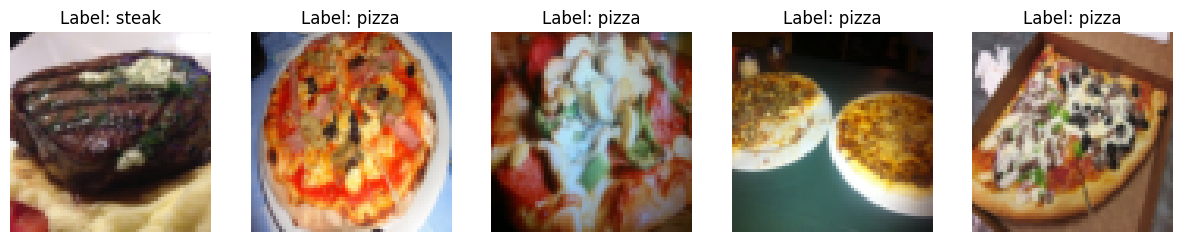

In [23]:
import matplotlib.pyplot as plt

batch = next(iter(train_loader))
images, labels = batch
classes = train_imageFolder.classes

fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
    axes[i].axis('off')
    axes[i].set_title(f"Label: {classes[labels[i]]}")


# Model

In [49]:
import torch
from torch import nn

class MiniVGG(nn.Module):
  def __init__(self,
               in_channels,
               hidden_channels,
               n_classes ):
    super().__init__()

    self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=hidden_channels,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(hidden_channels),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(hidden_channels),
            nn.MaxPool2d(kernel_size=(2,2),
                          stride=2,
                          padding=0),
            nn.Dropout(0.25)
          )

    self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(hidden_channels*2),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(hidden_channels*2),
            nn.MaxPool2d(kernel_size=(2,2),
                          stride=2,
                          padding=0),
            #nn.Dropout(0.25)
            )


    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_channels*16*16,
                  out_features=n_classes)
        )

  def forward(self, x):
    #x = self.block_1(x)
    #x = self.block_2(x)
    #x = self.linear(x)
    #return self.classification(self.block_3(self.block_2(self.block_1(x))))
    return self.classification(self.block_2(self.block_1(x)))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MiniVGG(3,10,3).to(device)
model

MiniVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [51]:
img = torch.randn(1,3,64,64).to(device)
pass_1 = model.conv_block_1(img)
pass_1.shape

torch.Size([1, 10, 32, 32])

In [52]:
pass_2 = model.conv_block_2(pass_1)
pass_2.shape

torch.Size([1, 10, 16, 16])

In [54]:
pass_3 = model.classifier(pass_2)
pass_3.shape

torch.Size([1, 3])

In [55]:
pass_3

tensor([[-0.0472, -0.0086, -0.0123]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [31]:
!pip install torchinfo

In [47]:
from torchinfo import summary

summary(model, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
MiniVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
│    └─Dropout: 2-6                      [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 10, 32, 32]           910
│    └─ReLU: 2-8                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 10, 32, 32]           910
│    └─ReLU: 2-10                        [1, 10, 32, 32]           --
│    └─MaxP

# Training

In [33]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.1 MB/s eta 0:00:00


In [56]:
from torch.optim import Adam, SGD

optimizer = Adam(model.parameters(), lr=0.001)
#optimizer = SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

In [63]:
def train(model: torch.nn.Module,
          dataLoader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          metric):

  model.train()
  train_loss, train_acc = 0, 0
  for X, y in dataLoader:
    X = X.to(device)
    y = y.to(device)

    # 1. Predictions
    y_pred = model(X)

    # 2. Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    metric.update(y_pred,y)
    train_acc += metric.compute()

    # 3. Gradient reset
    optimizer.zero_grad()

    # 4. Gradient Calculation
    loss.backward()

    # 5. Updating weights
    optimizer.step()

  train_loss /= len(dataLoader)
  train_acc /= len(dataLoader)

  return train_loss, train_acc

#print(f'Train loss: {loss_acum:.5f} | Train accuracy: {acc_acum:.2f}')

def eval(model: torch.nn.Module,
        dataLoader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        metric):

  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X,y in dataLoader:
      X = X.to(device)
      y = y.to(device)

      # 1. Predictions
      y_pred = model(X)

      # 2. Loss calculation
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      metric.update(y_pred,y)
      test_acc += metric.compute()

    test_loss /= len(dataLoader)
    test_acc /= len(dataLoader)

  return test_loss, test_acc

In [65]:
from torcheval.metrics import MulticlassAccuracy
from torch.nn import Softmax

epochs = 5
metric = MulticlassAccuracy()

model = MiniVGG(3,10,3).to(device)

for epoch in range(epochs):
  print(f'# Epoch: {epoch}')

  train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, metric)
  print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}')

  test_loss, test_acc =eval(model, test_loader, loss_fn, metric)
  print(f'Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}')

# Epoch: 0
Train loss: 1.09969 | Train accuracy: 0.30
Test loss: 1.09502 | Test accuracy: 0.33
# Epoch: 1
Train loss: 1.09753 | Train accuracy: 0.33
Test loss: 1.09562 | Test accuracy: 0.34
# Epoch: 2
Train loss: 1.09971 | Train accuracy: 0.34
Test loss: 1.09518 | Test accuracy: 0.34
# Epoch: 3
Train loss: 1.09739 | Train accuracy: 0.34
Test loss: 1.09552 | Test accuracy: 0.34
# Epoch: 4
Train loss: 1.09919 | Train accuracy: 0.34
Test loss: 1.09536 | Test accuracy: 0.34


In [ ]:
input = torch.randn(3, 5, requires_grad=True)
input

In [ ]:
target = torch.empty(3, dtype=torch.long).random_(5)
target

In [ ]:
metric.update(y_pred,y)
metric.compute()

In [ ]:
from torch.nn import Softmax

softmax = Softmax()
softmax(y_pred)

In [ ]:
loss_acum